In [69]:
import math
import geopy.distance
from dis import dis
import math
import geopandas as gpd
import numpy
from shapely import wkt
from shapely import wkb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.geocoders import Nominatim

%matplotlib inline

train_data = pd.read_csv('../data/stores_train.csv')
test_data = pd.read_csv('../data/stores_test.csv')
busstops = pd.read_csv('../data/busstops_norway.csv')
grunnkrets_age = pd.read_csv('../data/grunnkrets_age_distribution.csv')
grunnkrets_households = pd.read_csv('../data/grunnkrets_households_num_persons.csv')
grunnkrets_income = pd.read_csv('../data/grunnkrets_income_households.csv')
grunnkrets_stripped = pd.read_csv('../data/grunnkrets_norway_stripped.csv')
plaace_hierarchy = pd.read_csv('../data/plaace_hierarchy.csv')

In [70]:
def dist_to_all_km(lat, lon, df):

    # coordinates in radians
    lat1 = lat*math.pi/180
    lon1 = lon*math.pi/180
    lat2 = df['lat']*math.pi/180 # go through whole lat column
    lon2 = df['lon']*math.pi/180 # go through whole lon column

    # store original coordinates in new dataframe
    distances = pd.DataFrame()
    distances['lat'] = df['lat'].copy()
    distances['lon'] = df['lon'].copy()

    # calculate cartesian coordinates
    R = 6371 # Earth radius in km
    df['x'] = R*np.cos(lat2)*np.cos(lon2)
    df['y'] = R*np.cos(lat2)*np.sin(lon2)
    df['z'] = R*np.sin(lat2)
    x1 = R*np.cos(lat1)*np.cos(lon1)
    y1 = R*np.cos(lat1)*np.sin(lon1)
    z1 = R*np.sin(lat1)

    # calculate distance, store as new column in the distances dataframe
    distances['dist'] = np.sqrt(np.square(df['x']-x1)+np.square(df['y']-y1)+np.square(df['z']-z1))

    return distances['dist'].squeeze()

In [71]:
df = pd.DataFrame(train_data, columns=['store_id', 'lat', 'lon', 'grunnkrets_id'])
df = pd.merge(df, grunnkrets_stripped[['grunnkrets_id', 'municipality_name']], on='grunnkrets_id', how='left')
df = df.drop_duplicates(subset=['store_id'], keep='first').reset_index(drop=True)

# df.isnull().sum() # 30 NaNs in municipality_name

index_of_NaN, idy = np.where(pd.isnull(df))

for i in index_of_NaN:
    lat = df._get_value(i,'lat')
    lon = df._get_value(i,'lon')
    dist_to_all = dist_to_all_km(lat, lon, df).to_frame()
    dist_to_all = dist_to_all.sort_values('dist').reset_index()
    dist_to_all = dist_to_all.rename(columns={'index':'index_in_train_data'})

    # Find index of closest store that isn't itself and that has a grunnkrets_id
    index_of_closest_store = 0
    while dist_to_all.iloc[index_of_closest_store]['dist'] == 0 or pd.isna(df.at[dist_to_all.iloc[index_of_closest_store]['index_in_train_data'], 'municipality_name']):
        index_of_closest_store = index_of_closest_store + 1
    
    # Set municipality_name as the municipality name of the closest store that has one
    df.at[i,'municipality_name'] = df.at[dist_to_all.iloc[index_of_closest_store]['index_in_train_data'], 'municipality_name']


In [72]:
# Add municipality names
train_data = pd.merge(train_data, df[['grunnkrets_id', 'municipality_name']], on='grunnkrets_id', how='left')
# we get a bunch of duplicates of store_ids...? Remove them.
train_data = train_data.drop_duplicates(subset=['store_id'], keep='first')

# For test
test_data = pd.merge(test_data, df[['grunnkrets_id', 'municipality_name']], on='grunnkrets_id', how='left')
# we get a bunch of duplicates of store_ids...? Remove them.
test_data = test_data.drop_duplicates(subset=['store_id'], keep='first')

In [73]:
# Total nbr people in each grunnkrets
grunnkrets_age = grunnkrets_age.drop_duplicates(subset=['grunnkrets_id'], keep='last') # if there is value for 2016 we keep it, otherwise 2015
grunnkrets_age = grunnkrets_age.fillna(0)
grunnkrets_age = grunnkrets_age.drop('year',axis=1)
grunnkrets_age['grunnkrets_id'] = grunnkrets_age['grunnkrets_id'].astype(str)
grunnkrets_age['total_nbr_people'] = grunnkrets_age.sum(axis=1) # total number of inhabitants
grunnkrets_age['grunnkrets_id'] = grunnkrets_age['grunnkrets_id'].astype(int)
train_data = pd.merge(train_data, grunnkrets_age[['grunnkrets_id', 'total_nbr_people']], on='grunnkrets_id', how='left')
test_data = pd.merge(test_data, grunnkrets_age[['grunnkrets_id', 'total_nbr_people']], on='grunnkrets_id', how='left')

/var/folders/v4/l760qmd51vl3yg0k0ly6n5fw0000gn/T/ipykernel_6462/2295527476.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  grunnkrets_age['total_nbr_people'] = grunnkrets_age.sum(axis=1) # total number of inhabitants


In [74]:
# Replace NaN in mall_name and chain_name columns with 'No mall' and 'No chain'
train_data.mall_name = train_data.mall_name.fillna('No mall')
train_data.chain_name = train_data.chain_name.fillna('No chain')
# For test
test_data.mall_name = test_data.mall_name.fillna('No mall')
test_data.chain_name = test_data.chain_name.fillna('No chain')

# Dummy variable for mall or no mall
train_data.loc[train_data['mall_name'].str.contains("No mall", na=False),'mall_dummy'] = 0
train_data.loc[~(train_data['mall_name'].str.contains("No mall", na=False)),'mall_dummy'] = 1
train_data.drop(['mall_name'],axis=1, inplace=True)
# For test
test_data.loc[test_data['mall_name'].str.contains("No mall", na=False),'mall_dummy'] = 0
test_data.loc[~(test_data['mall_name'].str.contains("No mall", na=False)),'mall_dummy'] = 1
test_data.drop(['mall_name'],axis=1, inplace=True)

# 'store_name', 'year', 'sales_channel_name', 'address' columns are redundant, remove them
train_data = train_data.drop('store_name',axis=1)
train_data = train_data.drop('sales_channel_name',axis=1)
train_data = train_data.drop('address',axis=1)
# For test
test_data = test_data.drop('store_name',axis=1)
test_data = test_data.drop('sales_channel_name',axis=1)
test_data = test_data.drop('address',axis=1)

if train_data._get_value(1, 'revenue') > 15:
    train_data['revenue'] = np.log1p(train_data['revenue'])

In [75]:
######### MUNICIPALITY SIZE GROUPS #########

In [76]:
# Total nbr people in each municipality
municipalities = train_data[["municipality_name", "total_nbr_people"]].groupby(
    ["municipality_name"]
).sum().reset_index()

municipalities = municipalities.rename(columns={'total_nbr_people':'nbr_people_in_municipality'})

municipalities = municipalities.sort_values('nbr_people_in_municipality', ascending = False)

# Print distribution to check relevant division into small/medium/large municipality
# print(municipalities['nbr_people_in_municipality'].describe())
# plt.figure()
# sns.histplot(data=municipalities, x='nbr_people_in_municipality') # We see that two municipalities are very large, plot again without them
# plt.figure()
# sns.histplot(data=municipalities[municipalities['nbr_people_in_municipality']<500000], x='nbr_people_in_municipality') # excluding the two largest
# The above prints show reasonable splits for size groups, used below in conditions


# Make new column in municipalities for municipality size category, assign categories. Values are based on the above EDA of the distribution of nbr_people_in_municipality.
conditions = [
     (municipalities['nbr_people_in_municipality'] < 25000),
     (municipalities['nbr_people_in_municipality'] >= 25000) & (municipalities['nbr_people_in_municipality'] < 75000),
     (municipalities['nbr_people_in_municipality'] >= 75000) & (municipalities['nbr_people_in_municipality'] < 150000),
     (municipalities['nbr_people_in_municipality'] >= 150000) & (municipalities['nbr_people_in_municipality'] < 500000),
     (municipalities['nbr_people_in_municipality'] >= 500000),
 ]

values = ['below25k', 'between25and75k', 'between75and150k', 'between150and500k', 'above500k']
municipalities['municipality_size_group'] = np.select(conditions, values)

print(municipalities)

municipalities['municipality_size_group'].value_counts() # four size categories of 102-103 municipalities in each, category 0 is the 'No municipality name' one

# merge to train data
train_data = pd.merge(train_data, municipalities[['municipality_name', 'municipality_size_group']], on='municipality_name', how='outer')

# merge to test data
test_data = pd.merge(test_data, municipalities[['municipality_name', 'municipality_size_group']], on='municipality_name', how='outer')


    municipality_name  nbr_people_in_municipality municipality_size_group
243              Oslo                   2109973.0               above500k
26             Bergen                    565267.0               above500k
154      Kristiansand                    236806.0       between150and500k
348         Trondheim                    221814.0       between150and500k
309         Stavanger                    201526.0       between150and500k
..                ...                         ...                     ...
58            Etnedal                        91.0                below25k
268             Rødøy                        78.0                below25k
147           Karlsøy                         0.0                below25k
279            Sandøy                         0.0                below25k
69          Flatanger                         0.0                below25k

[410 rows x 3 columns]


In [77]:
# mean rev per municipality size group
mean_rev_munic = train_data[["municipality_size_group", "revenue"]].groupby(
    ["municipality_size_group"]
).mean().reset_index()
mean_rev_munic = mean_rev_munic.rename(columns={'revenue':'mean_revenue_for_municipality_size_group'})

# merge to train data
train_data = train_data.merge(mean_rev_munic, how="left", on=["municipality_size_group"])
# In case of duplicates, remove them.
train_data = train_data.drop_duplicates(subset=['store_id'], keep='first')

# merge to test data
test_data = test_data.merge(mean_rev_munic, how="left", on=["municipality_size_group"])
# In case of duplicates, remove them.
test_data = test_data.drop_duplicates(subset=['store_id'], keep='first')

In [78]:
# median rev per municipality size group
median_rev_munic = train_data[["municipality_size_group", "revenue"]].groupby(
    ["municipality_size_group"]
).median().reset_index()
median_rev_munic = median_rev_munic.rename(columns={'revenue':'median_revenue_for_municipality_size_group'})

# merge to train data
train_data = train_data.merge(median_rev_munic, how="left", on=["municipality_size_group"])
# In case of duplicates, remove them.
train_data = train_data.drop_duplicates(subset=['store_id'], keep='first')

# merge to test data
test_data = test_data.merge(median_rev_munic, how="left", on=["municipality_size_group"])
# In case of duplicates, remove them.
test_data = test_data.drop_duplicates(subset=['store_id'], keep='first')

In [79]:
# st dev per municipality size group
stdev_munic = train_data[["municipality_size_group", "revenue"]].groupby(
    ["municipality_size_group"]
).std().reset_index()
stdev_munic = stdev_munic.rename(columns={'revenue':'st_dev_of_revenue_for_municipality_size_group'})

# merge to train data
train_data = train_data.merge(stdev_munic, how="left", on=["municipality_size_group"])
# In case of duplicates, remove them.
train_data = train_data.drop_duplicates(subset=['store_id'], keep='first')

# merge to test data
test_data = test_data.merge(stdev_munic, how="left", on=["municipality_size_group"])
# In case of duplicates, remove them.
test_data = test_data.drop_duplicates(subset=['store_id'], keep='first')


In [ ]:
######### UP UNTIL HERE THINGS ARE DONE AND MAKE SENSE #########

######### FROM HERE ON IT IS NOT DONE, LOTS OF NAN #########

In [80]:
######### MUNICIPALITY REVENUE GROUPS #########

In [81]:
train_data = pd.merge(train_data, plaace_hierarchy[['plaace_hierarchy_id', 'lv1', 'lv2', 'lv3']], on='plaace_hierarchy_id', how='outer')
train_data['lv1']= train_data['lv1'].astype('category')
train_data['lv2']= train_data['lv2'].astype('category')
train_data['lv3']= train_data['lv3'].astype('category')

# For test
test_data = pd.merge(test_data, plaace_hierarchy[['plaace_hierarchy_id', 'lv1', 'lv2', 'lv3']], on='plaace_hierarchy_id', how='outer')
test_data['lv1']= test_data['lv1'].astype('category')
test_data['lv2']= test_data['lv2'].astype('category')
test_data['lv3']= test_data['lv3'].astype('category')

count    3115.000000
mean        1.590787
std         0.841953
min         0.000000
25%         1.006361
50%         1.506655
75%         2.085286
max         4.864545
Name: mean_revenue_for_municipality_and_level2, dtype: float64
     municipality_name  lv2  mean_revenue_for_municipality_and_level2  \
0              Agdenes  1.1                                       NaN   
1              Agdenes  1.2                                       NaN   
2              Agdenes  1.3                                       NaN   
3              Agdenes  1.4                                       NaN   
4              Agdenes  1.5                                       NaN   
...                ...  ...                                       ...   
8195     Øystre Slidre  3.2                                  0.829425   
8196     Øystre Slidre  3.3                                       NaN   
8197     Øystre Slidre  3.4                                       NaN   
8198     Øystre Slidre  3.5            

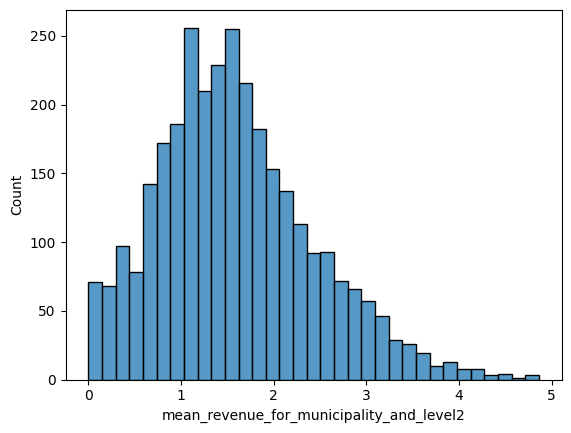

In [90]:
# Make municipality groups based on mean revenue for lv2 in each municipality

# Mean revenue for municipality and lv2
municipalities_rev = train_data[["municipality_name", "lv2", "revenue"]].groupby(
    ["municipality_name", "lv2"]
).mean().reset_index()
municipalities_rev = municipalities_rev.rename(columns={'revenue':'mean_revenue_for_municipality_and_level2'})

# Print distribution to check relevant division into small/medium/large municipality
print(municipalities_rev['mean_revenue_for_municipality_and_level2'].describe())
plt.figure()
sns.histplot(data=municipalities_rev, x='mean_revenue_for_municipality_and_level2')
# The above prints show reasonable splits for mean revenue groups, used below in conditions

# Make new column in municipalities_rev for municipality revenue category, assign categories
conds = [
     (municipalities_rev['mean_revenue_for_municipality_and_level2'] < 0.6),
     (municipalities_rev['mean_revenue_for_municipality_and_level2'] >= 0.6) & (municipalities_rev['mean_revenue_for_municipality_and_level2'] < 2.4),
     (municipalities_rev['mean_revenue_for_municipality_and_level2'] >= 2.4)
 ]
vals = ['low_rev_lv2', 'medium_rev_lv2', 'high_rev_lv2']
#municipalities_rev['municipality_rev_group_lv2'] = np.array(vals)[np.array(conds).argmax(axis=0)] #np.select(conds, vals)
municipalities_rev['municipality_rev_group_lv2'] = np.select(conds, vals)

print(municipalities_rev)
municipalities_rev['municipality_rev_group_lv2'].value_counts() # Varför en grupp med 0? De som saknar mean revenue lv2?

# merge to train data
train_data = pd.merge(train_data, municipalities_rev[['municipality_name', 'municipality_rev_group_lv2']], on='municipality_name', how='outer')

# merge to test data
test_data = pd.merge(test_data, municipalities_rev[['municipality_name', 'municipality_rev_group_lv2']], on='municipality_name', how='outer')



In [91]:
# mean rev per municipality rev group lv2
mean_rev_munic_lv2 = train_data[["municipality_rev_group_lv2", "revenue"]].groupby(
    ["municipality_rev_group_lv2"]
).mean().reset_index()
mean_rev_munic_lv2 = mean_rev_munic_lv2.rename(columns={'revenue':'mean_revenue_for_municipality_rev_group_lv2'})

# merge to train data
train_data = train_data.merge(mean_rev_munic_lv2, how="left", on=["municipality_rev_group_lv2"])
# In case of duplicates, remove them.
train_data = train_data.drop_duplicates(subset=['store_id'], keep='first')

# merge to test data
test_data = test_data.merge(mean_rev_munic_lv2, how="left", on=["municipality_rev_group_lv2"])
# In case of duplicates, remove them.
test_data = test_data.drop_duplicates(subset=['store_id'], keep='first')

KeyError: 'municipality_rev_group_lv2'

In [86]:

# antal folk => stor/medel/liten by - size groups DONE
# mean rev per municipality size group DONE
# st dev rev per municipality DONE
# median rev per municipality size group DONE

# gruppera kommuner på mean rev => high revenue municipalities/medium revenue municipalities/low revenue municipalities
# mean rev per municipality rev group and lv1
# mean rev per municipality rev group and lv2 DONE
# mean rev per municipality rev group and lv3
# median rev per municipality rev group and lv1
# median rev per municipality rev group and lv2
# median rev per municipality rev group and lv3
# st dev rev per municipality rev group and lv1
# st dev rev per municipality rev group and lv2
# st dev rev per municipality rev group and lv3
